## 2D Boussinesq (buoyancy-driven) flow example

### equations solved:
conservation of momentum (inviscid and incompressible form of Navier-Stokes equation)
$$
\partial_t v+\mathrm{\nabla}\cdot\left(v\otimes v\right)=-\mathrm{\nabla\pi}-g\frac{\theta^\prime}{\theta_0}
$$
conservation of energy
$$
\partial_t \theta+ \mathrm{\nabla}\cdot\left(v\theta\right)=0
$$
continuity equation(conservation of mass)
$$
\mathrm{\nabla}\cdot\ v=0
$$

In [297]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [298]:
from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim
from PyMPDATA import Options,ScalarField,VectorField,Solver,Stepper
from matplotlib import colors, pyplot
from PyMPDATA.boundary_conditions import Periodic
import numpy as np
from numba import jit
import warnings
import ipywidgets
from numba.core.errors import NumbaExperimentalFeatureWarning
from PyMPDATA.impl.enumerations import IMPL_META_AND_DATA, META_AND_DATA_DATA, IMPL_BC
from IPython.display import display

## non-JIT-compilable (yet) functions

In [364]:
_U = 0
_W = 1
_T = 2

@jit
def data(impl):
    return impl[IMPL_META_AND_DATA][META_AND_DATA_DATA]
@jit
def grad(psi,dxy,axis):
#can add halo comprehension, current code assumes halo = 2 #wait, does it suggest only 1 halo matters?
    if axis == 0: #assuming x is 0 and y is 1
        return (psi[3:len(psi)-1,2:-2]-psi[1:(len(psi)-3),2:-2])/2/dxy
    elif axis == 1:
        return (psi[2:-2,3:len(psi)-1]-psi[2:-2,1:(len(psi)-3)])/2/dxy
    else:
        ArithmeticError("unsupported number of axis")
def calc_gc_interpolate_in_space(advector: VectorField, stash, dt:float, dxy: tuple):
    idx_diff = ( 
        (slice(None, -1), slice(None, None)),
        (slice(None, None), slice(None, -1)),
    )
    for axis in (0, 1):
        advector.data[axis][:] = dt / dxy[axis] * (
            np.diff(stash[axis], axis=axis) / 2 + stash[axis][idx_diff[axis]]
        )[:]
        
@jit
def ini_pressure(Phi, solvers, N, M,h):
    npoints = N*M
    for k in (0, 1):
        Phi[h:-h,h:-h][:] -= 0.5 * np.power(solvers[k].advectee.get()[:],2)
    Phi_mean = np.sum(Phi[h:-h,h:-h])/ npoints
    Phi[h:-h,h:-h][:] -= Phi_mean

@jit    
def div(lap_tmp,dxy,h):
    return (
        grad(lap_tmp[0], dxy[0],axis=0) +
        grad(lap_tmp[1], dxy[1],axis=1)
    )

@jit
def lap(Phi, dxy, err_init, lap_tmp,h, tmp_uvw = np.empty(1)): 
    xchng_pres_old(Phi,h)
    calc_grad_Phi(lap_tmp, Phi, dxy,h)

    if err_init:
        for k in (0, 1):
            lap_tmp[k][:] -= tmp_uvw[k]

    for k in (0, 1):
        xchng_pres_old(lap_tmp[k],h)
        
    return div(lap_tmp, dxy,h)

@jit
def pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw,h):
    p_err[0][h:-h,h:-h][:] = err[h:-h,h:-h]
    lap_p_err[0][:] = lap(p_err[0], dxy, False, lap_tmp,h,tmp_uvw)

#@njit
def pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,dxy,
                              k_iters,err_tol,lap_err,lap_tmp,h):
    tmp_den = [1.]*k_iters
    alpha = [1.]*k_iters
    for v in range(0,k_iters):
        tmp_den[v] = np.sum(lap_p_err[v]**2)
        if tmp_den[v] != 0:
            beta = - np.dot(
            err[h:-h,h:-h].ravel(),
            lap_p_err[v].ravel()
            ) / tmp_den[v]
        Phi[h:-h,h:-h][:] += beta * p_err[v][h:-h,h:-h]
        err[h:-h,h:-h][:] += beta * lap_p_err[v]

        error = max(
            abs(np.amax(err[h:-h,h:-h])),
            abs(np.amin(err[h:-h,h:-h]))
        )

        if error <= err_tol: 
            converged = True

        lap_err[:] = lap(err, dxy, False, lap_tmp,h)

        for l in range(v):
            if tmp_den[l] != 0:
                alpha[l] = - np.dot(lap_err.ravel(), lap_p_err[l].ravel()) / tmp_den[l]
        if v < k_iters - 1:
            p_err[v + 1][h:-h,h:-h][:] = err[h:-h,h:-h]
            lap_p_err[v + 1][:] = lap_err
            for l in range(v):
                p_err[v + 1][h:-h,h:-h][:] += alpha[l] * p_err[l][h:-h,h:-h]
                lap_p_err[v + 1][:] += alpha[l] * lap_p_err[l]
        else:
            p_err[0][h:-h,h:-h][:] = err[h:-h,h:-h][:] + alpha[0] * p_err[0][h:-h,h:-h]
            lap_p_err[0][:] = lap_err[:] + alpha[0] * lap_p_err[0]
            for l in range(1,v+1):
                p_err[0][h:-h,h:-h][:] += alpha[l] * p_err[l][h:-h,h:-h]
                lap_p_err[0][:] += alpha[l] * lap_p_err[l]
    return converged

#@njit
def pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,
                           lap_p_err,dxy,k_iters,err_tol,lap_err,h):
    for k in (0, 1):
        tmp_uvw[k][:] = solvers[k].advectee.data
    
    #initial error
    err[h:-h,h:-h][:] = lap(Phi, dxy, True,lap_tmp,h,tmp_uvw)

    iters = 0
    converged = False

    pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw,h)
    #pseudo-time loop
    while not converged:        
        converged = pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,
                                               dxy,k_iters,err_tol,lap_err,lap_tmp,h)
        iters += 1

        if iters > 10000: # going beyond 10000 iters means something is really wrong,
            # usually boundary conditions but not always !
            raise ArithmeticError("stuck in pressure solver")
             
    xchng_pres_old(Phi,h)
    calc_grad_Phi(tmp_uvw, Phi, dxy,halo)

#@njit
def calc_grad(arg : ScalarField, Phi, dxy,h):
    idx = (slice(h,-h),slice(h,-h))
    for k in (0,1):
        data(arg[k])[idx] = np.gradient(Phi.data[:], dxy[k], axis=k)[idx]
@jit
def calc_grad_Phi(arg : ScalarField, Phi, dxy,h):
    idx = (slice(h,-h),slice(h,-h))
    for k in (0,1):
        arg[k][idx] = grad(Phi[:], dxy[k], axis=k)

## Parameters

In [365]:
# TODO: put in a named tuple or dict

outfreq = 1

N, M  = 20, 20
dxy = 2000/(N), 2000/(M)
Tht_ref = 300.
g = 9.81
r0 = 250.
dt = 7.5
nt = int(600//dt)
beta  = 0.25
prs_tol = 1e-7
err_tol = prs_tol/dt
k_iters = 4

assert dt * nt == 600

## initial condition

In [366]:
xi, yi = np.indices((N, M))
mask = np.sqrt(((xi+1/2)*dxy[0]-1000)**2+((yi+1/2)*dxy[1]-260)**2) < r0

mesh = np.full((N,M), fill_value=Tht_ref, dtype=float)
mesh += np.where(mask, 0.5, 0)

## PyMPDATA setup

In [367]:
options = Options(n_iters=2, infinite_gauge= True,nonoscillatory = True)
bcond = (Periodic(), Periodic())

halo = options.n_halo
field_ctor_kwargs = {'halo': halo, 'boundary_conditions': bcond}

advector = VectorField(data=(np.zeros((N+1, M)), np.zeros((N, M+1))), **field_ctor_kwargs)
stepper = Stepper(options=options, grid=(N, M),n_threads = 1)

def new_sf(N, M):
    field = ScalarField(data=np.zeros((N,M)), **field_ctor_kwargs)
    field.assemble(stepper.traversals)
    return field

def new_sfs(N, M, impl=False):
    return tuple(new_sf(N,M).impl if impl else new_sf(N,M) for _ in ('u', 'w'))

solver_ctor_kwargs = {'stepper': stepper, 'advector': advector}
solvers = {
    _U: Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
    _W: Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
    _T: Solver(advectee=ScalarField(data=mesh, **field_ctor_kwargs), **solver_ctor_kwargs),
}
advectee_data = tuple(
    solvers[idx].advectee.data for idx in range(3)
)

rhs_w = np.zeros((N,M))
stash = np.zeros((2,N+halo*2,M+halo*2))
vip_rhs = new_sfs(N, M, impl=True)
Phi = np.zeros((N+halo*2,M+halo*2))
tmp_uvw = np.zeros((2,N+halo*2,M+halo*2))
lap_tmp = np.zeros((2,N+halo*2,M+halo*2))
lap_err = np.zeros((N,M))
err = np.zeros((N+halo*2,M+halo*2))
p_err = np.zeros((k_iters,N+halo*2,M+halo*2))
lap_p_err = np.zeros((k_iters,N,M))

## JIT-compilable functions

In [368]:
fill_halos_scalar = stepper.traversals._code["fill_halos_scalar"]

@jit(**options.jit_flags)
def xchng_pres(impl):
    fill_halos_scalar(0, *impl[IMPL_META_AND_DATA], impl[IMPL_BC], None)

@jit(**options.jit_flags)
def calc_gc_extrapolate_in_time(solvers, stash,halo):
    for k in (0, 1):
        stash[k][halo:-halo,halo:-halo] = -.5 * stash[k][halo:-halo,halo:-halo] + 1.5 * solvers[k]
        stash[k][halo:-halo,halo:-halo] = -.5 * stash[k][halo:-halo,halo:-halo] + 1.5 * solvers[k]
        xchng_pres_old(stash[k],halo)   
@jit
def fill_stash(solvers, stash,halo):
    for k in (0, 1):
        stash[k][halo:-halo,halo:-halo] = solvers[k]
        xchng_pres_old(stash[k],halo)
        
@jit(**options.jit_flags)
def xchng_pres_old(data,h):
    data[0:h,:] = data[-2*h:-h,:]
    data[-h:,:] = data[h:2*h,:]
    data[:,0:h] = data[:,-2*h:-h]
    data[:,-h:] = data[:,h:2*h]


@jit(**options.jit_flags)
def vip_rhs_apply(dt, vip_rhs, advectee_data):
    for k in (0, 1):
        advectee_data[k][:] += 0.5 * dt * data(vip_rhs[k])
        data(vip_rhs[k])[:] = 0

@jit(**options.jit_flags)
def apply_rhs(w, rhs_w : np.ndarray, dt : float):
    w += rhs_w * dt
    
@jit(**options.jit_flags)
def update_rhs(tht : np.ndarray, rhs_w : np.ndarray, tht_ref : int, g : float):
    rhs_w[:] = g * (tht - tht_ref) / tht_ref

@jit(**options.jit_flags)
def pressure_solver_apply(advectee_data, tmp_uvw,h):
    for k in (0, 1):
        advectee_data[k][:] -= tmp_uvw[k]

## Simulation loop
Progress bar stays at 0 until all functions compile

In [370]:
#%%time
progress = ipywidgets.FloatProgress(max=nt)
display(progress)

output = np.empty((nt//outfreq+1,N,M))
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore",category= NumbaExperimentalFeatureWarning)

    Phi[halo:-halo,halo:-halo][:] = 0
    pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,
                           k_iters,err_tol,lap_err,halo)
    xchng_pres_old(Phi[:],halo)
    calc_grad_Phi(tmp_uvw, Phi, dxy,halo)
    pressure_solver_apply(advectee_data, tmp_uvw,halo)

    ini_pressure(Phi,solvers,N,M,halo)
    xchng_pres_old(Phi[:],halo)
    calc_grad_Phi(tmp_uvw, Phi, dxy,halo)
    for k in (0,1):
        data(vip_rhs[k])[:] -= tmp_uvw[k]

    for step in range(nt + 1):
        if step != 0:
            calc_gc_extrapolate_in_time(np.array([solvers[0].advectee.get()
                                        ,solvers[1].advectee.get()]), 
                                        stash,halo) 

            calc_gc_interpolate_in_space(advector, stash,dt,dxy) 
            fill_stash(np.array([solvers[0].advectee.get(),solvers[1].advectee.get()]), stash,halo) # writes to stash
            apply_rhs(solvers[_W].advectee.get(), rhs_w, dt/2)

            vip_rhs_apply(dt, vip_rhs, advectee_data)
    
            for solver in solvers.values():
                solver.advance(n_steps=1)
    
            update_rhs(tht=solvers[_T].advectee.get(), rhs_w=rhs_w, g=g, tht_ref=Tht_ref)
            apply_rhs(solvers[_W].advectee.get(), rhs_w, dt/2)
    
            for k in (0,1):
                data(vip_rhs[k])[:] = -solvers[k].advectee.data
    
            pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,
                                   lap_p_err,dxy,k_iters,err_tol,lap_err,halo)
            pressure_solver_apply(advectee_data, tmp_uvw,halo)
    
            for k in (0, 1):
                data(vip_rhs[k])[:] += solvers[k].advectee.data
                data(vip_rhs[k])[:] /= 0.5 * dt
            
        if step % outfreq == 0:
            output[step] = solvers[_T].advectee.get().copy()
        progress.value = step
with open("output.npy", 'wb') as f:
    np.save(f, np.array(output))

FloatProgress(value=0.0, max=80.0)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\Castlefox\AppData\Local\Temp\ipykernel_43984\1692556875.py (27)[0m
[1m
File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_43984\1692556875.py", line 27:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 1: [1mCannot determine Numba type of <class 'dict'>[0m 

This error may have been caused by the following argument(s):
- argument 1: [1mCannot determine Numba type of <class 'dict'>[0m


## Visualisation

FloatProgress(value=0.0, max=8.1)


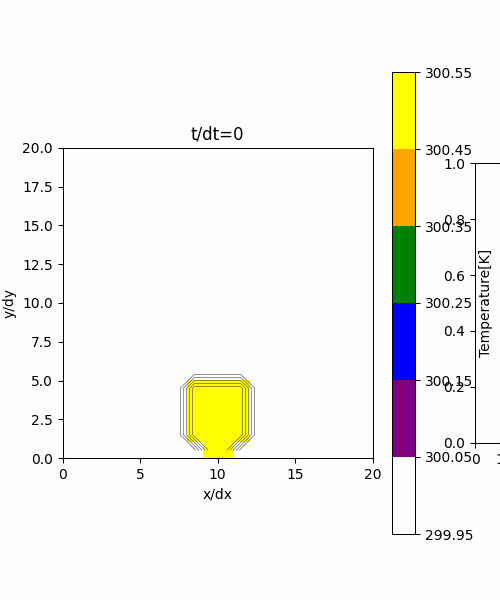

HTML(value="<a href='.\\tmpjrsqw84r.gif' target='_blank'>.\\tmpjrsqw84r.gif</a><br>")

In [345]:
freq = int(10)
progress = ipywidgets.FloatProgress(max=len(output)/freq)

def plot(step,plotflag=False):
    data = output[step]
    grid = data.shape
    x, y = np.indices(grid)
    colorticks = np.linspace(299.95, 300.55, 7, endpoint=True)
    cmap = colors.ListedColormap(["white", "purple", "blue", "green","orange","yellow"])

    fig = pyplot.figure(figsize=(5,6))
    pyplot.title("t/dt="+str(step))
    pyplot.xlabel("x/dx")
    pyplot.ylabel("y/dy")
    pyplot.contour(x+1/2, y+1/2, data, levels=colorticks[1:], colors='k',linewidths=0.3)
    pyplot.imshow(data.T, origin="lower", extent=(0, grid[0], 0, grid[1]),
                  cmap=cmap, vmin=colorticks[0], vmax=colorticks[-1])
    cax = pyplot.axes([0.95, 0.262, 0.05,0.466])
    if plotflag:
        pyplot.colorbar(ticks=colorticks,label = "Temperature[K]",cax = cax)
    else:
        pyplot.colorbar(ticks=colorticks,label = "Temperature[K]")
    progress.value += 1
    return fig
    
display(progress)
show_anim(plot, frame_range=range(len(output))[::freq])

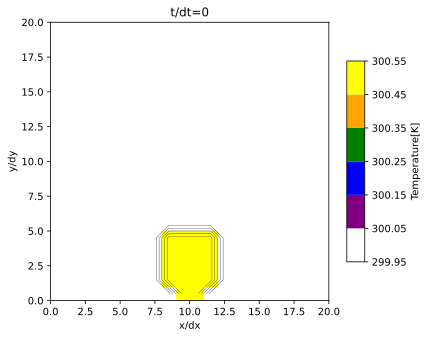

In [338]:
show_plot(fig=plot(0,True))


In [253]:
show_plot(fig=plot(800,True))

IndexError: index 800 is out of bounds for axis 0 with size 81